# Histopathologic Cancer Detection
## Identify metastatic tissue in histopathologic scans of lymph node sections
In this workbook we'll develop a Pytorch based binary classifier to identify metastatic cancer in small image patches taken from larger digital pathology scans. This is a Kaggle Competition challenge and, [details can be found here](https://www.kaggle.com/c/histopathologic-cancer-detection). Data for this challenge has been downloaded from the competion's website and saved locally under the `./data/Kaggle/histo` folder.

In [2]:
# set this flag to True when you run this Notebook on Google Collaboratory
USE_COLAB = False

import os

#@see: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q
if USE_COLAB:
    # Load the Drive helper and mount
    from google.colab import drive

    # We mount our Goofgle Drive to this foloder - following line will prompt for authorization.
    gdrive_mount_point = '/content/drive/'
    drive.mount(gdrive_mount_point)
    grive_path = os.path.join(gdrive_mount_point, "My Drive/")
    print('Your Google Drive is mounted at ', grive_path)
    COLAB_NOTEBOOKS_PATH = os.path.join(grive_path, "Colab Notebooks/")
    PYTORCH_COLAB_NOTEBOOKS_PATH = os.path.join(COLAB_NOTEBOOKS_PATH, 'pytorch')
    
    if os.path.exists(PYTORCH_COLAB_NOTEBOOKS_PATH):
        print('You Pytorch Colab notebooks are available at ', PYTORCH_COLAB_NOTEBOOKS_PATH)

        # append our Google Drive folder to module search 
        import sys
        sys.path.append(PYTORCH_COLAB_NOTEBOOKS_PATH)
        print(f'NOTE: {PYTORCH_COLAB_NOTEBOOKS_PATH} is appended to sys.path!')
        # and test it - following line should NOT throw an exception!
        import pytorch_toolkit as pytk
        MODEL_SAVE_DIR = os.path.join(PYTORCH_COLAB_NOTEBOOKS_PATH, 'model_states')
        IMAGES_ZIP_DIR = "/content/drive/My Drive/Colab Notebooks/data/kaggle/fruits360"
    else:
        raise IOError("Unable to mount Google Drive!")
else:
    MODEL_SAVE_DIR = os.path.join('.','model_states')
    IMAGES_ZIP_DIR = "./images/pytorch/fruits360"
    
if not os.path.exists(MODEL_SAVE_DIR):
    os.mkdir(MODEL_SAVE_DIR)
    
print(f"MODEL_SAVE_DIR = {MODEL_SAVE_DIR}")

MODEL_SAVE_DIR = ./model_states


In [3]:
import warnings
warnings.filterwarnings('ignore')

import sys, os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from PIL import Image, ImageDraw
%matplotlib inline

# tweaks for libraries
np.set_printoptions(precision=6, linewidth=1024, suppress=True)
plt.style.use('seaborn')
sns.set_style('darkgrid')
sns.set_context('notebook',font_scale=1.10)

# Pytorch imports
import torch
gpu_available = torch.cuda.is_available()
print('Using Pytorch version %s. GPU %s available' % (torch.__version__, "IS" if gpu_available else "IS **NOT**"))
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import optim
from torchsummary import summary

# import the Pytorch Toolkit here....
import pytorch_toolkit as pytk

# to ensure that you get consistent results across various machines
# @see: https://discuss.pytorch.org/t/reproducibility-over-different-machines/63047
seed = 123
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = True

Using Pytorch version 1.7.1+cpu. GPU IS **NOT** available


### Exploring the Dataset

In [4]:
DATA_FOLDER = os.path.join('.','data','Kaggle','histo')
print(DATA_FOLDER)

./data/Kaggle/histo


In [7]:
DATA_FILE_NAME = 'train_labels.csv'
DATA_FILE_PATH = os.path.join(DATA_FOLDER, DATA_FILE_NAME)
print(f"DATA_FILE_PATH: {DATA_FILE_PATH}")
assert os.path.exists(DATA_FILE_PATH), f"{DATA_FILE_PATH} - path does not exist!"

DATA_FILE_PATH: ./data/Kaggle/histo/train_labels.csv


AssertionError: ./data/Kaggle/histo/train_labels.csv - path does not exist!

In [5]:
# let's open the labels file & explore the data
labels = pd.read_csv(DATA_FILE_PATH)
labels.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

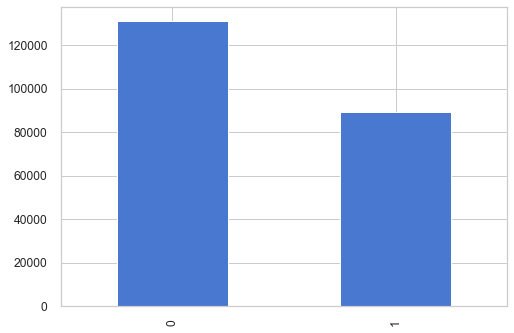

In [6]:
labels['label'].value_counts().plot(kind='bar');

Let's look at some malignant images

In [7]:
malignant_df = labels.loc[labels['label'] == 1]
malignant_image_names = malignant_df['id'].values

In [8]:
nrows, ncols = 5, 5
rand_ids = np.random.randint(0, len(malignant_image_names), nrows * ncols)
random_image_ids = malignant_image_names[rand_ids]

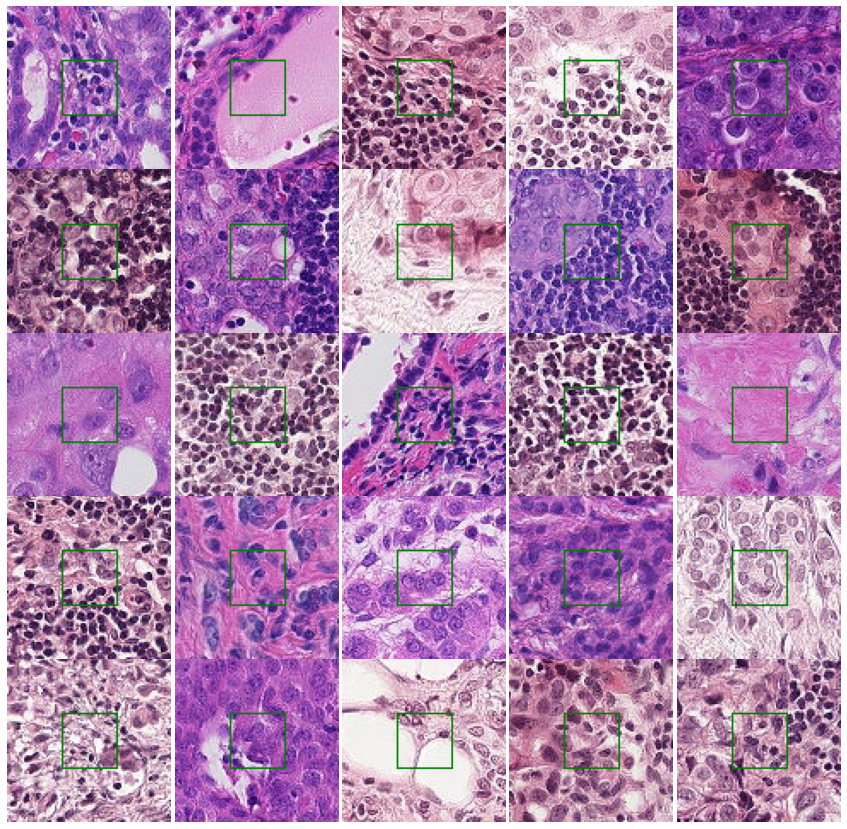

In [9]:
old_figsize = plt.rcParams['figure.figsize']

plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.subplots_adjust(wspace=0, hspace=0)

# let's display 25 randomly selected images in a 5x5 grid
for i, image_id in enumerate(random_image_ids):
    image_path = os.path.join(DATA_FOLDER, 'train', image_id + '.tif')
    # load the image & draw
    img = Image.open(image_path)
    # draw a 32*32 rectangle
    draw = ImageDraw.Draw(img)
    draw.rectangle(((32, 32), (64, 64)),outline="green")
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(np.array(img))
    plt.axis('off')
    
plt.rcParams['figure.figsize'] = old_figsize

In [10]:
# shuffle the dataframe
labels = labels.sample(frac=1).reset_index(drop=True)
labels.head()

id  label
0  b209f66d707a314a580848b550e4afcc551324f5      1
1  12c44b00365a71455af5b9d6fda26211178793a2      1
2  51b4a47373cbd898abadc4b46453e83e618d387e      0
3  dcfb669cb82c7ad12fd56e8be7d07a29a65eb5ee      1
4  d8200d76fd2f1c1e8e2faef7ee7e85c41e1fd785      1

In [11]:
len(labels)

220025

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(labels['id'], labels['label'], test_size=0.30, random_state=seed)
X_train.shape, y_train.shape, X_test.shape, y_test.shape
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.20, random_state=seed)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((154017,), (154017,), (52806,), (52806,), (13202,), (13202,))

In [13]:
X_train_image_paths = [os.path.join(DATA_FOLDER, 'train', image_id + '.tif') for image_id in X_train.values]
X_train_image_paths[:5]

['.\\data\\Kaggle\\histo\\train\\6eaddbd20b1f6e5fe713bf3464b5844d91f7746a.tif',
 '.\\data\\Kaggle\\histo\\train\\37846069ada4ed839b9b58bd23c3c508d3a12699.tif',
 '.\\data\\Kaggle\\histo\\train\\3cbce055e9069cd500ab71871eee9aa03e471d62.tif',
 '.\\data\\Kaggle\\histo\\train\\7826e3a4971168e7ed744b1fbb3ec1d099ca25b8.tif',
 '.\\data\\Kaggle\\histo\\train\\4162ad0f5d5432719d5507f3271a8d14c3c8cd11.tif']

In [14]:
X_val_image_paths = [os.path.join(DATA_FOLDER, 'train', image_id + '.tif') for image_id in X_val.values]
X_val_image_paths[:5]

['.\\data\\Kaggle\\histo\\train\\c7ec1fbe301340f3399193f5081cb6000aa33a5b.tif',
 '.\\data\\Kaggle\\histo\\train\\c9365fd5b976638875b6b64b79950e68cf7e0ca4.tif',
 '.\\data\\Kaggle\\histo\\train\\c4750b540e15fd11106e41b2af91d7c544595717.tif',
 '.\\data\\Kaggle\\histo\\train\\a4c4b00dab4e6822d27811df73a10ba840378d41.tif',
 '.\\data\\Kaggle\\histo\\train\\15618a3b6c488212812252b7c69ed1a31ef2a032.tif']

In [15]:
X_test_image_paths = [os.path.join(DATA_FOLDER, 'train', image_id + '.tif') for image_id in X_test.values]
X_test_image_paths[:5]

['.\\data\\Kaggle\\histo\\train\\39a1194d2e9369a77aa41ebff9a17ee8d48ea5ec.tif',
 '.\\data\\Kaggle\\histo\\train\\eb373756486b3312ad71609a6421a0a5ef028092.tif',
 '.\\data\\Kaggle\\histo\\train\\93f68b377f70c73ef517a2f49b0b39f693e5746a.tif',
 '.\\data\\Kaggle\\histo\\train\\38b0e5675ce33531df4e7a7f7f84110f58009c81.tif',
 '.\\data\\Kaggle\\histo\\train\\83f3914bd24f1344e527dcc1ca08e7b77db8fa87.tif']

In [16]:
y_train, y_val, y_test = y_train.values, y_val.values, y_test.values

In [17]:
def display_sample(sample_images, sample_labels, sample_predictions=None, grid_shape=(8,8),
                   plot_title=None, fig_size=None):
    """ display a random selection of images & corresponding labels, optionally with predictions
        The display is laid out in a grid of num_rows x num_col cells
        If sample_predictions are provided, then each cell's title displays the prediction 
        (if it matches actual) or actual/prediction if there is a mismatch
    """
    from PIL import Image
    import seaborn as sns

    num_rows, num_cols = grid_shape

    assert len(sample_images) == num_rows * num_cols

    # a dict to help encode/decode the labels
    LABELS = {
        1 : 'Malignant',
        0 : 'Benign'
    }
    
    with sns.axes_style("whitegrid"):
        sns.set_context("notebook", font_scale=1.1)
        sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

        f, ax = plt.subplots(num_rows, num_cols, figsize=((20, 20) if fig_size is None else fig_size),
            gridspec_kw={"wspace": 0.02, "hspace": 0.25}, squeeze=True)
        #fig = ax[0].get_figure()
        f.tight_layout()
        f.subplots_adjust(top=0.95)

        for r in range(num_rows):
            for c in range(num_cols):
                image_index = r * num_cols + c
                ax[r, c].axis("off")

                # show selected image
                sample_image = sample_images[image_index]
                # got image as (NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)
                sample_image = sample_image.transpose((1,2,0))
                #sample_image = sample_image * 0.5 + 0.5  # since we applied this normalization
                sample_image *= 255.0

                ax[r, c].imshow(sample_image)
                
                if sample_predictions is None:
                    # show the actual labels in the cell title
                    title = ax[r, c].set_title("%s" % LABELS[sample_labels[image_index]])
                else:
                    # else check if prediction matches actual value
                    true_label = sample_labels[image_index]
                    pred_label = sample_predictions[image_index]
                    prediction_matches_true = (true_label == pred_label)
                    if prediction_matches_true:
                        # if actual == prediction, cell title is prediction shown in green font
                        title = LABELS[true_label]
                        title_color = 'g'
                    else:
                        # if actual != prediction, cell title is actua/prediction in red font
                        title = '%s\n%s' % (LABELS[true_label], LABELS[pred_label])
                        title_color = 'r'
                    # display cell title
                    title = ax[r, c].set_title(title)
                    plt.setp(title, color=title_color)
        # set plot title, if one specified
        if plot_title is not None:
            f.suptitle(plot_title)

        plt.show()
        plt.close()

## Define the dataset

In [18]:
from torch.utils.data.dataset import Dataset

class HistoDataset(Dataset):
    def __init__(self, image_paths, labels, transforms):
        self.image_paths = image_paths
        self.labels = labels
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        """
        Open a PIL image, resize to (IMAGE_HEIGHT, IMAGE_WIDTH), apply transforms (if any) & convert to Numpy array
        and return array and label at index
        """
        image_path = self.image_paths[index]
        assert(os.path.exists(image_path)), f'Invalid path - {image_path} does not exist!'
        img = Image.open(image_path)
        if self.transforms is not None:
            img = self.transforms(img)
        img = np.array(img).astype(np.float32)
        img /= 255.0
        label = int(self.labels[index])
        return (img, label)

In [19]:
# we are scaling all images to same size + converting them to tensors & normalizing data
xforms = {
    'train': transforms.Compose([
#         transforms.RandomAffine(0, shear=0.2),         # random shear 0.2
#         transforms.RandomAffine(0, scale=(0.8, 1.2)),  # random zoom 0.2
#         transforms.RandomHorizontalFlip(),   
#         transforms.RandomVerticalFlip(),      
        transforms.ToTensor(),
    ]),
    'eval': transforms.Compose([
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
    ]),
}

In [20]:
train_dataset = HistoDataset(X_train_image_paths, y_train, xforms['train'])
eval_dataset = HistoDataset(X_val_image_paths, y_val, xforms['eval'])
test_dataset = HistoDataset(X_test_image_paths, y_test, xforms['test'])
print(len(train_dataset), len(X_train_image_paths), len(eval_dataset), len(X_val_image_paths), \
      len(test_dataset), len(X_test_image_paths))

154017 154017 52806 52806 13202 13202


Dataset: image.shape = torch.Size([64, 3, 96, 96]), labels.shape = torch.Size([64])


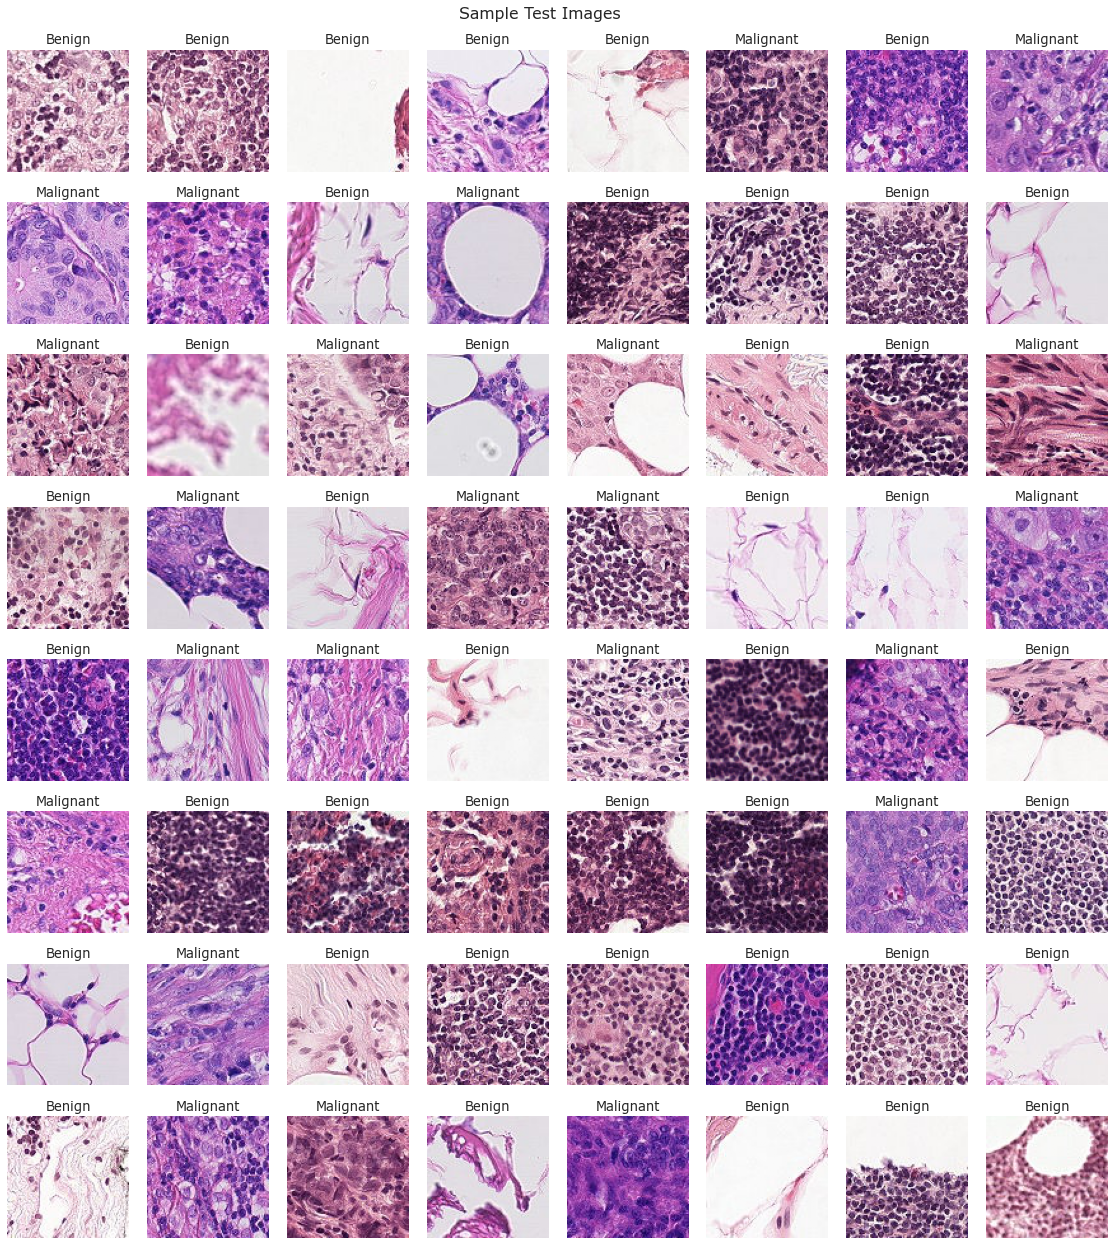

In [21]:
loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)
data_iter = iter(loader)
sample_images, sample_labels = data_iter.next()  # fetch first batch of 64 images & labels
print(f'Dataset: image.shape = {sample_images.shape}, labels.shape = {sample_labels.shape}')
display_sample(sample_images.numpy(), sample_labels.numpy(), plot_title="Sample Test Images");

## Define the model

In [22]:
IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS, NUM_CLASSES = 96, 96, 3, 2
NUM_EPOCHS, BATCH_SIZE, LR_RATE, L2_REG = 25, 64, 0.001, 0.0005

In [27]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

cnn_model = nn.Sequential(
    pytk.Conv2d(NUM_CHANNELS, 8, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(8),
    nn.MaxPool2d(kernel_size=2, stride=2),

    pytk.Conv2d(8, 16, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(16),
    nn.MaxPool2d(kernel_size=2, stride=2),

    pytk.Conv2d(16, 32, 3, padding=0),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(kernel_size=2, stride=2),

    pytk.Conv2d(32, 64, 3, padding=0),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(kernel_size=2, stride=2),

    Flatten(),

    nn.Linear(64*4*4, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.25),

    nn.Linear(512, NUM_CLASSES)    
)

In [28]:
model = pytk.PytkModuleWrapper(cnn_model)
print(model.summary((NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 96, 96]             224
              ReLU-2            [-1, 8, 96, 96]               0
       BatchNorm2d-3            [-1, 8, 96, 96]              16
         MaxPool2d-4            [-1, 8, 48, 48]               0
            Conv2d-5           [-1, 16, 48, 48]           1,168
              ReLU-6           [-1, 16, 48, 48]               0
       BatchNorm2d-7           [-1, 16, 48, 48]              32
         MaxPool2d-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 32, 22, 22]           4,640
             ReLU-10           [-1, 32, 22, 22]               0
      BatchNorm2d-11           [-1, 32, 22, 22]              64
        MaxPool2d-12           [-1, 32, 11, 11]               0
           Conv2d-13             [-1, 64, 9, 9]          18,496
             ReLU-14             [-1, 6

In [29]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(params=model.parameters(), lr=LR_RATE, momentum=0.8, nesterov=False, weight_decay=L2_REG)
optimizer = optim.Adam(params=model.parameters(), lr=LR_RATE, weight_decay=L2_REG)
model.compile(loss=criterion, optimizer=optimizer, metrics=['acc'])

In [ ]:
hist = model.fit_dataset(train_dataset, validation_dataset=eval_dataset, epochs=10, 
                         batch_size=BATCH_SIZE, num_workers=3)

Training on CPU...
Training on 154017 samples, cross-validating on 52806 samples
